Número de formas detectadas: 3
Área promedio: 51507.67 píxeles
Perímetro promedio: 928.29 píxeles


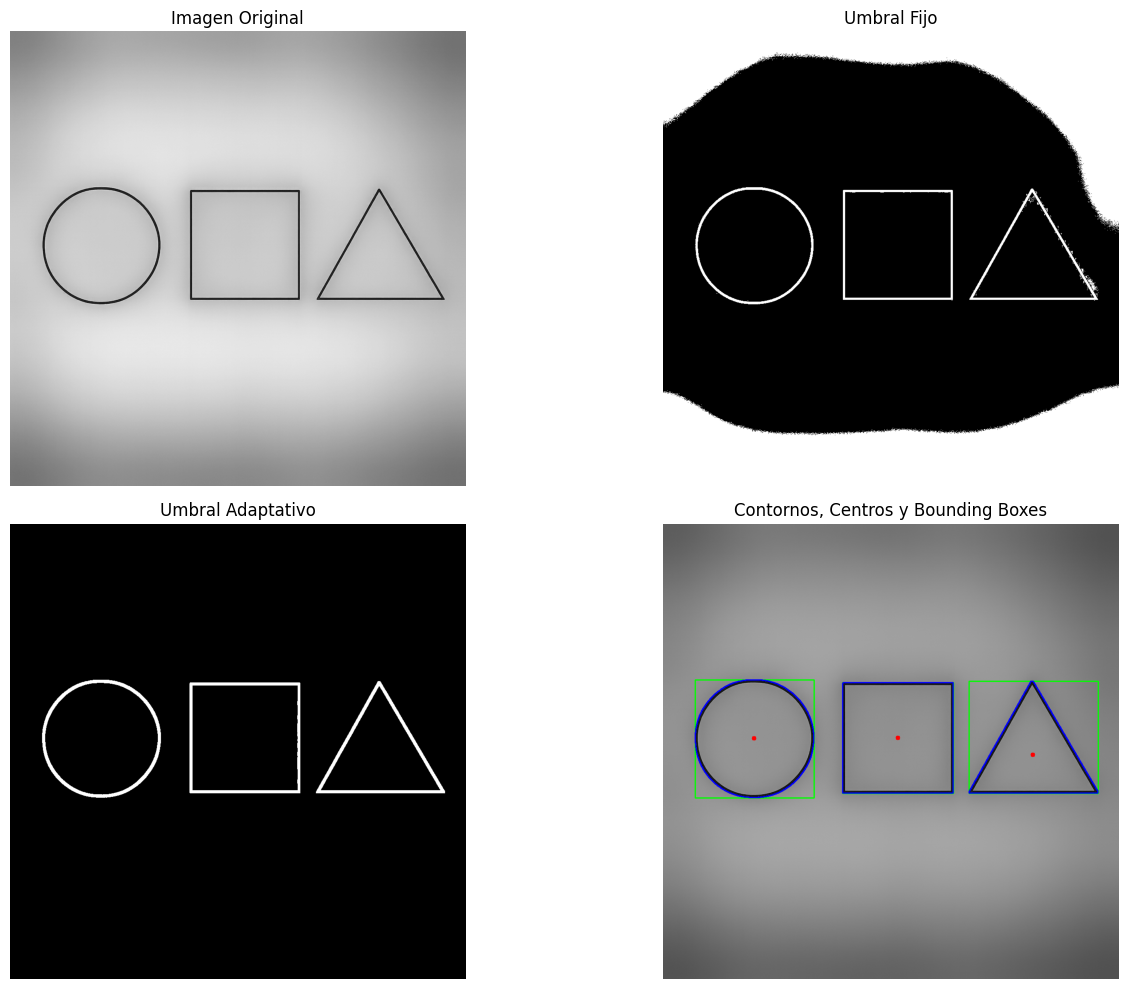

GIF generado: segmentation_results.gif


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Importar cv2_imshow para Colab
import time  # Para añadir un retraso entre cuadros
import imageio.v2 as imageio  # Para generar el GIF

# Función para cargar y preprocesar un cuadro
def preprocesar_cuadro(imagen):
    # Convertir a escala de grises si no lo está
    if len(imagen.shape) == 3:
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    return imagen

# Función para aplicar umbralización
def aplicar_umbralizacion(imagen):
    # Umbral fijo inverso
    _, umbral_fijo = cv2.threshold(imagen, 127, 255, cv2.THRESH_BINARY_INV)

    # Umbral adaptativo
    umbral_adaptativo = cv2.adaptiveThreshold(
        imagen, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 21, 5
    )

    # Aplicar dilatación para engrosar los contornos
    kernel = np.ones((3, 3), np.uint8)
    umbral_adaptativo = cv2.dilate(umbral_adaptativo, kernel, iterations=1)

    return umbral_fijo, umbral_adaptativo

# Función para detectar contornos y calcular métricas
def detectar_contornos(imagen_binaria, imagen_original):
    # Encontrar contornos
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convertir imagen original a color para dibujar
    if len(imagen_original.shape) == 2:
        imagen_color = cv2.cvtColor(imagen_original, cv2.COLOR_GRAY2BGR)
    else:
        imagen_color = imagen_original.copy()

    # Listas para métricas
    areas = []
    perimetros = []

    # Procesar cada contorno
    for idx, contorno in enumerate(contornos):
        # Calcular área y perímetro
        area = cv2.contourArea(contorno)
        perimetro = cv2.arcLength(contorno, True)
        areas.append(area)
        perimetros.append(perimetro)

        # Calcular centro de masa
        momentos = cv2.moments(contorno)
        if momentos['m00'] != 0:
            cx = int(momentos['m10'] / momentos['m00'])
            cy = int(momentos['m01'] / momentos['m00'])
            # Dibujar centro de masa
            cv2.circle(imagen_color, (cx, cy), 5, (0, 0, 255), -1)

        # Calcular y dibujar bounding box
        x, y, w, h = cv2.boundingRect(contorno)
        cv2.rectangle(imagen_color, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Dibujar contorno
        cv2.drawContours(imagen_color, [contorno], -1, (255, 0, 0), 2)

    # Calcular métricas promedio
    num_formas = len(contornos)
    area_promedio = np.mean(areas) if areas else 0
    perimetro_promedio = np.mean(perimetros) if perimetros else 0

    return imagen_color, num_formas, area_promedio, perimetro_promedio

# Función para generar el GIF animado
def generar_gif(imagen_original, umbral_adaptativo, imagen_contornos, nombre_salida="segmentation_results.gif"):
    # Lista para almacenar las imágenes del GIF
    imagenes = []

    # Redimensionar todas las imágenes a 600x600 píxeles y convertir a RGB
    # Imagen original
    if len(imagen_original.shape) == 2:
        img_orig_rgb = cv2.cvtColor(imagen_original, cv2.COLOR_GRAY2RGB)
    else:
        img_orig_rgb = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2RGB)
    img_orig_resized = cv2.resize(img_orig_rgb, (600, 600))
    imagenes.append(img_orig_resized)

    # Imagen con umbral adaptativo
    umbral_rgb = cv2.cvtColor(umbral_adaptativo, cv2.COLOR_GRAY2RGB)
    umbral_resized = cv2.resize(umbral_rgb, (600, 600))
    imagenes.append(umbral_resized)

    # Imagen con contornos
    contornos_rgb = cv2.cvtColor(imagen_contornos, cv2.COLOR_BGR2RGB)
    contornos_resized = cv2.resize(contornos_rgb, (600, 600))
    imagenes.append(contornos_resized)

    # Generar el GIF
    imageio.mimsave(nombre_salida, imagenes, duration=1000)
    print(f"GIF generado: {nombre_salida}")

# Función para procesar un video en Colab
def procesar_secuencia(fuente):
    # Abrir el video
    cap = cv2.VideoCapture(fuente)

    if not cap.isOpened():
        raise ValueError("No se pudo abrir el video.")

    max_cuadros = 50  # Límite de cuadros para no saturar la salida en Colab
    cuadro_actual = 0

    while cuadro_actual < max_cuadros:
        # Leer un cuadro
        ret, cuadro = cap.read()
        if not ret:
            break

        # Preprocesar el cuadro
        cuadro_gris = preprocesar_cuadro(cuadro)

        # Aplicar umbralización
        umbral_fijo, umbral_adaptativo = aplicar_umbralizacion(cuadro_gris)

        # Detectar contornos
        cuadro_contornos, num_formas, area_promedio, perimetro_promedio = detectar_contornos(umbral_adaptativo, cuadro)

        # Mostrar métricas en el cuadro
        texto = f"Formas: {num_formas} | Area Prom: {area_promedio:.2f} | Perim Prom: {perimetro_promedio:.2f}"
        cv2.putText(cuadro_contornos, texto, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        # Mostrar resultados usando cv2_imshow
        print(f"Cuadro {cuadro_actual + 1}:")
        cv2_imshow(cuadro)  # Imagen original
        cv2_imshow(umbral_adaptativo)  # Umbral adaptativo
        cv2_imshow(cuadro_contornos)  # Contornos, centros y bounding boxes

        # Añadir un pequeño retraso para evitar saturar la salida
        time.sleep(0.5)
        cuadro_actual += 1

    # Liberar recursos
    cap.release()

# Función para procesar una imagen estática (como en el código original)
def procesar_imagen_estatica(ruta_imagen):
    # Cargar imagen
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    if imagen is None:
        raise ValueError("No se pudo cargar la imagen.")

    # Aplicar umbralización
    umbral_fijo, umbral_adaptativo = aplicar_umbralizacion(imagen)

    # Detectar contornos
    imagen_contornos, num_formas, area_promedio, perimetro_promedio = detectar_contornos(umbral_adaptativo, imagen)

    # Mostrar métricas
    print(f"Número de formas detectadas: {num_formas}")
    print(f"Área promedio: {area_promedio:.2f} píxeles")
    print(f"Perímetro promedio: {perimetro_promedio:.2f} píxeles")

    # Visualizar resultados con matplotlib
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.title("Imagen Original")
    plt.imshow(imagen, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Umbral Fijo")
    plt.imshow(umbral_fijo, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title("Umbral Adaptativo")
    plt.imshow(umbral_adaptativo, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title("Contornos, Centros y Bounding Boxes")
    plt.imshow(cv2.cvtColor(imagen_contornos, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('resultados_segmentacion.png')
    plt.show()

    # Generar el GIF con las tres imágenes solicitadas
    generar_gif(imagen, umbral_adaptativo, imagen_contornos, nombre_salida="segmentation_results.gif")

# Función principal
def main(modo="imagen", fuente="formas.png"):
    if modo == "imagen":
        procesar_imagen_estatica(fuente)
    elif modo == "video":
        procesar_secuencia(fuente)
    else:
        raise ValueError("Modo no válido. Usa 'imagen' o 'video'. El modo 'webcam' no está soportado en Colab.")

# Ejemplo de ejecución
if __name__ == "__main__":
    # Cambia el modo según lo que desees probar
    modo = "imagen"  # Para generar el GIF, usamos el modo "imagen"
    fuente = "formas.png"  # Asegúrate de que la imagen esté en el directorio

    # Si quieres probar con el video, usa:
    # modo = "video"
    # fuente = "video.mp4"

    main(modo, fuente)